In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp -r drive/MyDrive/IFT780/TP2/prog/* .

# Pytorch

Dans ce notebook, nous reproduirons le modèle conçu dans le notebook précédent, mais avec Pytorch !
Pytorch est une bibliothèque permettant de concevoir et entraîner des réseaux de neurones facilement, gérant pour vous la propagation entre les couches, la rétropropagation, l'optimisation du modèle, l'utilisation du GPU, et plus.

Pour commencer, il est conseillé de lire en bonne partie l'introduction à Pytorch ici:
https://pytorch.org/tutorials/beginner/basics/intro.html

In [2]:
import random
import numpy as np
import time
from utils.data_utils import load_CIFAR10, display_images
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Pour automatiquement recharger les modules externes
# voir http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
# %cd datasets
# !ls
# !bash -x ./get_datasets.sh
# %cd ../

In [4]:
from layers.BatchNorm import SpatialBatchNorm
from layers.Conv import Conv2DCython
from layers.Dense import Dense
from layers.Flatten import Flatten
from layers.MaxPool import MaxPool2DCython
from layers.Dropout import Dropout
from model.Model import Model
from utils.model_loss import cross_entropy_loss
from model.Solver import epoch_solver, Adam

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500, num_batch=200):
    """
    Charger la banque de données CIFAR-10, prétraiter les images et ajouter une dimension pour le biais.
    
    Input :
    - num_training : nombre d'images à mettre dans l'ensemble d'entrainement
    - num_validation : nombre d'images à mettre dans l'ensemble de validation
    - num_test : nombre d'images à mettre dans l'ensemble de test
    - num_dev : d'images à mettre dans l'ensemble dev
    
    Output :
    - X_train, y_train : données et cibles d'entrainement
    - X_val, y_val: données et cibles de validation
    - X_test y_test: données et cibles de test 
    - X_dev, y_dev: données et cibles dev
    - X_batch, y_batch: batch de données et de cibles 
    """
    # Charger les données CIFAR-10
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test, label_names = load_CIFAR10(cifar10_dir)
  
    # Séparer en ensembles d'entraînement, de validation, de test et de dev
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    mask = range(num_batch)
    X_batch = X_train[mask]
    y_batch = y_train[mask]
    
    X_train = X_train.transpose(0, 3, 1, 2)
    X_test = X_test.transpose(0, 3, 1, 2)
    X_val = X_val.transpose(0, 3, 1, 2)
    X_dev = X_dev.transpose(0, 3, 1, 2)

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, X_batch, y_batch, label_names 

def preprocess_CIFAR10_data(X):

    # Normalisation
    X_mean = np.mean(X, axis = 0)
    X_ = X - X_mean
    
    return X_

Data_train, y_train, Data_val, y_val, Data_test, y_test, Data_dev, y_dev, Data_batch, y_batch, label_names = get_CIFAR10_data()
X_train, X_val, X_test, X_dev, X_batch, = (preprocess_CIFAR10_data(Data) for Data in (Data_train, Data_val, Data_test, Data_dev, Data_batch))

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)
print('batch data shape: ', X_batch.shape)
print('batch labels shape: ', y_batch.shape)

print("CIFAR10 est un jeu de données d'images RGB 32x32x3 séparées en 10 classes")
print(label_names)

Train data shape:  (49000, 3, 32, 32)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3, 32, 32)
Test labels shape:  (1000,)
dev data shape:  (500, 3, 32, 32)
dev labels shape:  (500,)
batch data shape:  (200, 32, 32, 3)
batch labels shape:  (200,)
CIFAR10 est un jeu de données d'images RGB 32x32x3 séparées en 10 classes
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Modèle en numpy

Premièrement, recréons le modèle précédemment implémenté:

In [6]:
# paramètres de convolution, à modifier au besoin
filter_size = 3
channels = 3
stride = 1
p_dropout = 0.4
pad = int((filter_size - 1)/2)

# paramètres dense
num_classes = 10

def create_Nlayer_cnn(init_weight_scale):

    # TODO: Copier-coller ici votre architecture numpy de la dernière question
    model = Model()
    layer0 = Conv2DCython(32, 
                          filter_size=filter_size,
                          channels=channels, 
                          stride=stride,
                          padding=pad,
                          weight_scale=init_weight_scale,
                          activation="relu")
    
    layer1 = Conv2DCython(32, 
                          filter_size=filter_size,
                          channels=32, 
                          stride=stride,
                          padding=pad,
                          weight_scale=init_weight_scale,
                          activation="relu")
    
    layer2 = Conv2DCython(64, 
                          filter_size=filter_size,
                          channels=32, 
                          stride=stride,
                          padding=pad,
                          weight_scale=init_weight_scale,
                          activation="relu")
    
    layer3 = Conv2DCython(64, 
                          filter_size=filter_size,
                          channels=64, 
                          stride=stride,
                          padding=pad,
                          weight_scale=init_weight_scale,
                          activation="relu")
    
    layer_fc_0 = Dense(dim_input=4096,
                     dim_output=512,
                     weight_scale=init_weight_scale,
                     activation="relu")
    
    
    layer_fc_1 = Dense(dim_input=512,
                     dim_output=num_classes,
                     weight_scale=init_weight_scale,)
    
    model.add(layer0)
    model.add(layer1)
    model.add(MaxPool2DCython(pooling_size=2, stride=2))
    model.add(SpatialBatchNorm(32))
    model.add(Dropout(drop_rate=p_dropout))
    
    model.add(layer2)
    model.add(layer3)
    model.add(MaxPool2DCython(pooling_size=2, stride=2))
    model.add(SpatialBatchNorm(64))
    model.add(Dropout(drop_rate=p_dropout))
        
    model.add(Flatten())
    model.add(layer_fc_0)
    model.add(Dropout(drop_rate=0.5))
    model.add(layer_fc_1)
    model.add_loss(cross_entropy_loss)
    
    
    return model    

reg = 1e-4 # à ajuster au besoin
lr = 5e-4  # à ajuster au besoin
model = create_Nlayer_cnn(1e-2)

optimizer = Adam(lr, model)
    
# On entraîne (1 epoch) avec 100% des données d'entraînement.
st = time.time()
loss_history, train_accuracy_history, val_accuracy_history = epoch_solver(X_train, 
                                                                          y_train,
                                                                          X_val,
                                                                          y_val,
                                                                          reg,
                                                                          optimizer,
                                                                          batch_size=100,
                                                                          epochs=1)
print(f'Total execution time: {time.time() - st:.2f} seconds')

(batch 20 / 490) loss: 1.769119
(batch 40 / 490) loss: 1.677936
(batch 60 / 490) loss: 1.593558
(batch 80 / 490) loss: 1.503377
(batch 100 / 490) loss: 1.440432
(batch 120 / 490) loss: 1.408843
(batch 140 / 490) loss: 1.372213
(batch 160 / 490) loss: 1.514217
(batch 180 / 490) loss: 1.175492
(batch 200 / 490) loss: 1.238564
(batch 220 / 490) loss: 1.409465
(batch 240 / 490) loss: 1.226803
(batch 260 / 490) loss: 1.216122
(batch 280 / 490) loss: 1.294356
(batch 300 / 490) loss: 1.214813
(batch 320 / 490) loss: 1.156706
(batch 340 / 490) loss: 1.227033
(batch 360 / 490) loss: 1.080724
(batch 380 / 490) loss: 1.041149
(batch 400 / 490) loss: 1.003287
(batch 420 / 490) loss: 1.044244
(batch 440 / 490) loss: 1.029340
(batch 460 / 490) loss: 1.069085
(batch 480 / 490) loss: 1.124010
(epoch 1 / 1) loss: 0.907076, train_acc: 0.646041, val_acc: 0.620000
Total execution time: 1048.06 seconds


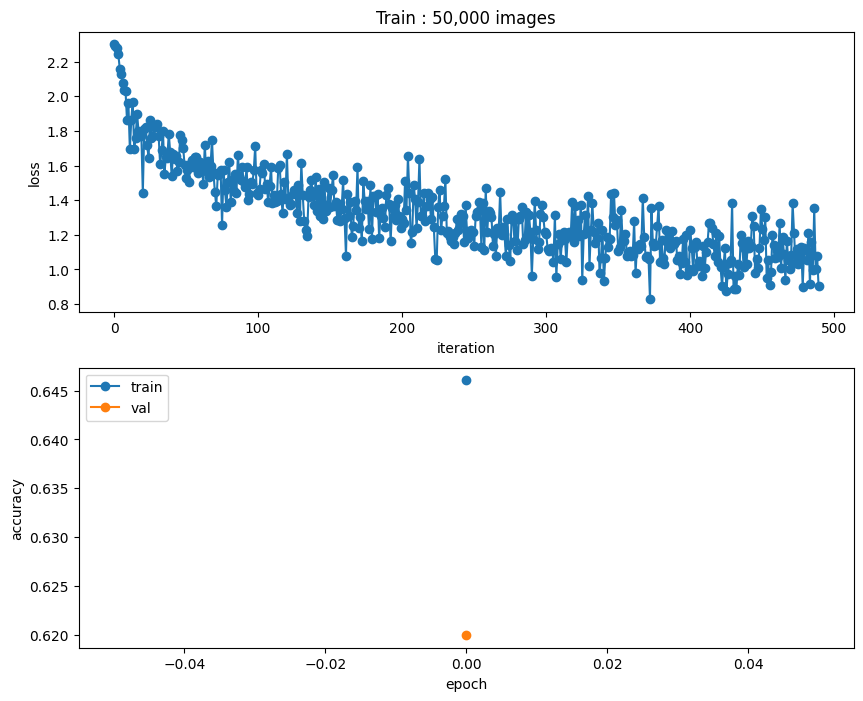

Total execution time: 0.13 seconds


In [7]:
st = time.time()
plt.subplot(2, 1, 1)
plt.plot(loss_history, '-o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Train : 50,000 images')

plt.subplot(2, 1, 2)
plt.plot(train_accuracy_history, '-o')
plt.plot(val_accuracy_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()
print(f'Total execution time: {time.time() - st:.2f} seconds')

In [8]:
y_test_pred = model.predict(X_test)

test_acc = (y_test_pred == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.633


## Modèle en pytorch

Maintenant, recréons le modèle avec Pytorch. Tout d'abord, un peu de mise en place.

In [9]:
import os
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [10]:
# On se crée tout d'abord un dataset permettant d'acceuillir les données
# À noter que Pytorch offre déjà des façons de charger CIFAR-10, mais pour les besoins de la cause
# faisons-le nous-même:
import multiprocessing as mp

params = {'batch_size': 100,
          'shuffle': False,
          'num_workers': 0,
          # 'pin_memory':True,
         }

class CIFAR10Dataset(torch.utils.data.Dataset):
  def __init__(self, data, labels):
        self.labels = labels
        self.data = data

  def __len__(self):
        return len(self.data)

  def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]

        return x, y


# Alors que le dataset permet d'accéder aux données, le "DataLoader" permet de les charger en "batch" (et
# potentiellement avec plusieurs workers)
train_pyt = CIFAR10Dataset(X_train, y_train)
training_generator = torch.utils.data.DataLoader(train_pyt, **params)
# print(type(training_generator))
# for i, (batch, labels) in enumerate(training_generator):
#     print()

valid_pyt = CIFAR10Dataset(X_val, y_val)
valid_generator = torch.utils.data.DataLoader(valid_pyt, **params)

test_pyt = CIFAR10Dataset(X_test, y_test)
test_generator = torch.utils.data.DataLoader(test_pyt, **params)

In [13]:
# paramètres de convolution, à modifier au besoin
filter_size = 3
channels = 3
stride = 1
p_dropout = 0.4
pad = int((filter_size - 1)/2)

# paramètres dense
num_classes = 10

# source: https://github.com/pytorch/examples/blob/main/dcgan/main.py#L95
def weights_init(m, init_weight_scale):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        torch.nn.init.normal_(m.weight, 0.0, init_weight_scale)
    elif classname.find('Linear') != -1:
        torch.nn.init.normal_(m.weight, 0.0, init_weight_scale)
        torch.nn.init.zeros_(m.bias)

# On se crée une classe pour notre modèle
class NeuralNetwork(nn.Module):
    def __init__(self, stack: nn.Sequential):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.stack = stack
        
    def forward(self, x):
        out = self.stack(x)
        return out

# On emboîte les layers dans nn.Sequential, permettant de simplifier le code de la propagation avant
# Ce n'est pas nécéssaire en général, mais pour simplifier le code du travail pratique, on le fait comme ça:
def create_cnn_stack(init_weight_scale):
    
    # TODO: Convertir votre modèle numpy en modules pytorch   
    # remplacer -1 par le modèle créé
    stack = nn.Sequential(
        nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=filter_size,
                  stride=stride,padding=pad),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=filter_size,
                  stride=stride,padding=pad),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.BatchNorm2d(32),
        nn.Dropout2d(p=p_dropout),
        
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=filter_size,
                  stride=stride,padding=pad),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=filter_size,
                  stride=stride, padding=pad),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.BatchNorm2d(64),
        nn.Dropout2d(p=p_dropout),
        
        nn.Flatten(),
        nn.Linear(4096, 512),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(512, num_classes),
    )
    
    stack.apply(lambda m: weights_init(m, init_weight_scale))
        
    return stack

In [14]:
reg = 1e-4 # à ajuster au besoin
lr = 5e-4  # à ajuster au besoin
stack = create_cnn_stack(1e-2)

# On instancie le modèle en y passant la "stack" le couches
model_pyt = NeuralNetwork(stack).to(device)

# On se déclare un optimiseur qui effectuera la descente de gradient
optimizer_pyt = optim.Adam(model_pyt.parameters(), lr=lr, weight_decay=reg)

# On se déclare une loss
loss_fn = nn.CrossEntropyLoss()

loss_history, train_accuracy_history, valid_accuracy_history = [], [], []

# On optimise ! Le code plus bas remplace la classe Solver précédemment définie
epochs = 1
for epoch in range(epochs):
    training_accuracy = []
    valid_accuracy = []
    st = time.time()
    for i, (batch, labels) in enumerate(training_generator):
        
        batch = batch.float().to(device)
        if device == 'cuda':
            batch = batch.cuda()
        
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        
        logits = model_pyt(batch)
        preds = torch.argmax(logits, dim=-1)
        accuracy = torch.sum(preds == labels) / len(batch)
        
        loss = loss_fn(logits, labels)
        
        optimizer_pyt.zero_grad()
        loss.backward()
        optimizer_pyt.step()
        
        training_accuracy.append(accuracy)
        loss_history.append(loss.cpu().detach().numpy())
        # loss_history.append(loss.detach().numpy())
        
        if i % 20 == 0:
            print('batch {} / {} loss : {}'.format(i, len(training_generator), loss))
            
    with torch.no_grad():
        for i, (batch, labels) in enumerate(valid_generator):
            batch = batch.float().to(device)
            if device == 'cuda':
                batch = batch.cuda()
            labels = labels.to(device)
        
            logits = model_pyt(batch)
            preds = torch.argmax(logits, dim=-1)
            accuracy = torch.sum(preds == labels) / len(batch)
            valid_accuracy.append(accuracy)
            
    mean_epoch_train_acc = torch.mean(torch.stack(training_accuracy))        
    mean_epoch_valid_acc = torch.mean(torch.stack(valid_accuracy))     
    train_accuracy_history.append(mean_epoch_train_acc)
    valid_accuracy_history.append(mean_epoch_valid_acc)
    print(f"(epoch {epoch + 1} / {epochs}) loss: {loss}, train_acc: {mean_epoch_train_acc}, val_acc: {mean_epoch_valid_acc}")
print(f'Total execution time: {time.time() - st:.2f} seconds')

batch 0 / 490 loss : 2.317174196243286
batch 20 / 490 loss : 2.0255494117736816
batch 40 / 490 loss : 1.792203426361084
batch 60 / 490 loss : 1.677010178565979
batch 80 / 490 loss : 1.6265312433242798
batch 100 / 490 loss : 1.498153567314148
batch 120 / 490 loss : 1.552404761314392
batch 140 / 490 loss : 1.4352988004684448
batch 160 / 490 loss : 1.595943570137024
batch 180 / 490 loss : 1.3159953355789185
batch 200 / 490 loss : 1.4964666366577148
batch 220 / 490 loss : 1.5192736387252808
batch 240 / 490 loss : 1.2869911193847656
batch 260 / 490 loss : 1.110853672027588
batch 280 / 490 loss : 1.3674129247665405
batch 300 / 490 loss : 1.3027163743972778
batch 320 / 490 loss : 1.4348366260528564
batch 340 / 490 loss : 1.5023983716964722
batch 360 / 490 loss : 1.3743293285369873
batch 380 / 490 loss : 1.343680739402771
batch 400 / 490 loss : 1.060505747795105
batch 420 / 490 loss : 1.3508740663528442
batch 440 / 490 loss : 1.1312956809997559
batch 460 / 490 loss : 1.1080092191696167
batch 4

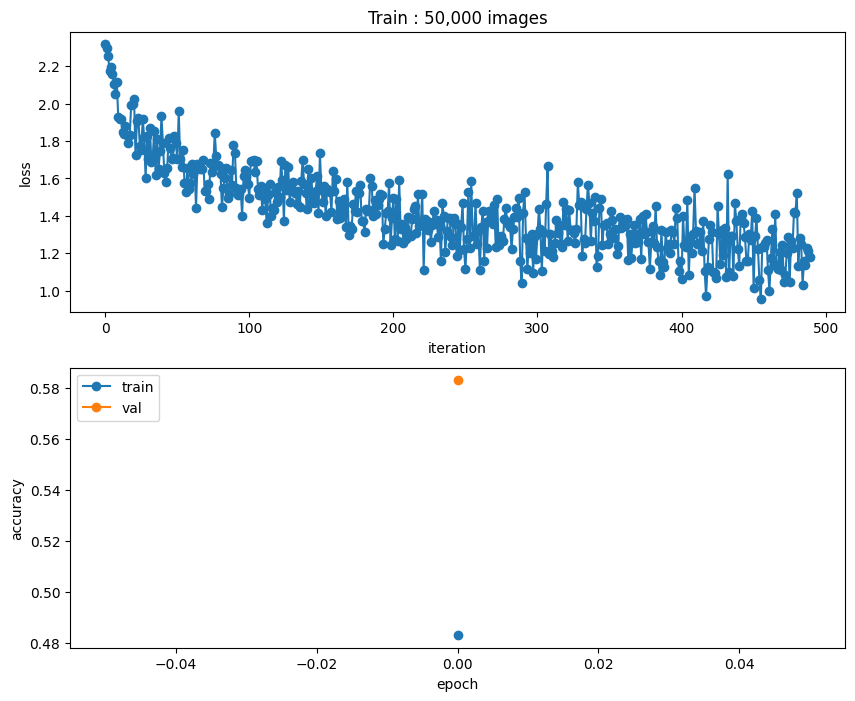

Total execution time: 0.10 seconds


In [15]:
st = time.time()
plt.subplot(2, 1, 1)
plt.plot(loss_history, '-o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Train : 50,000 images')

plt.subplot(2, 1, 2)
plt.plot(train_accuracy_history[0].cpu().detach().numpy(), '-o')
plt.plot(valid_accuracy_history[0].cpu().detach().numpy(), '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()
print(f'Total execution time: {time.time() - st:.2f} seconds')

Si tout s'est bien déroulé, vous devriez avoir une accuracy en validation et en test avec Pytorch semblable à celle en numpy !

Test accuracy:  0.583


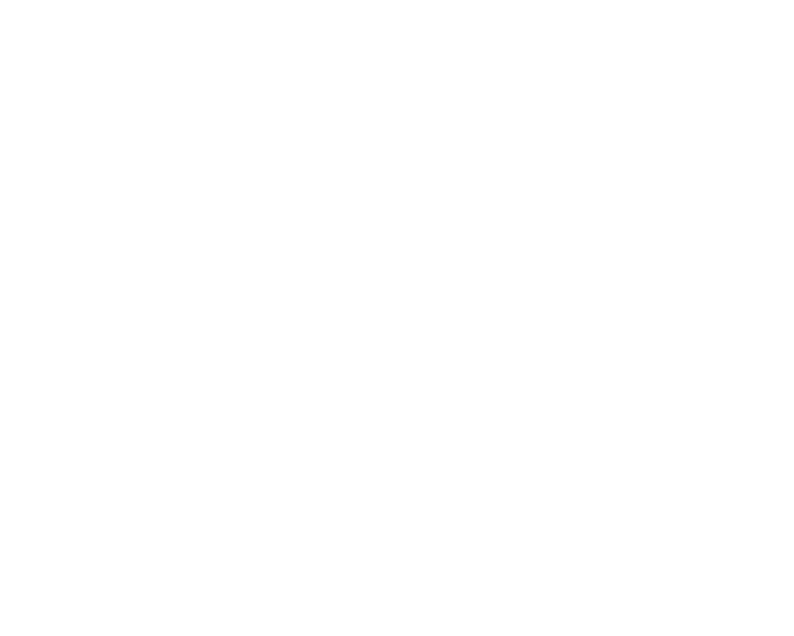

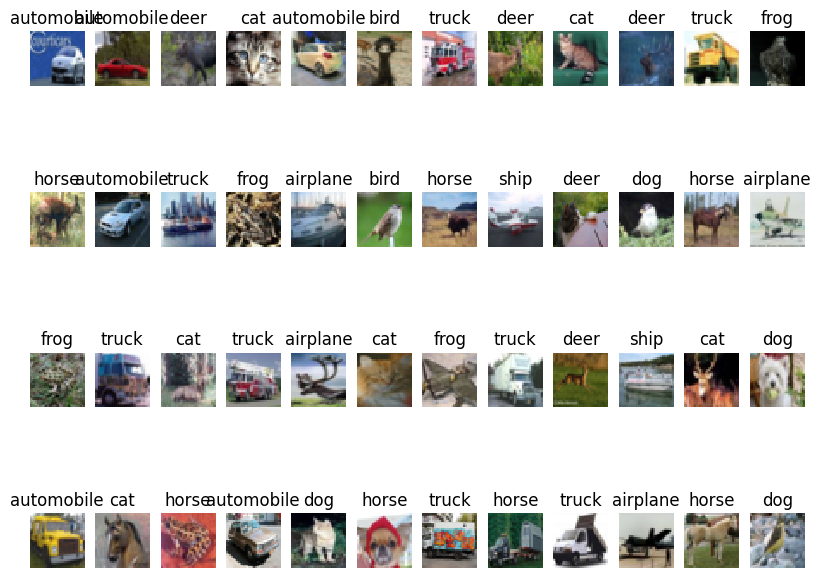

In [25]:
epochs = 1
test_accuracy = []
test_preds = []
with torch.no_grad():
    for i, (batch, labels) in enumerate(test_generator):
        batch = batch.float().to(device)
        if device == 'cuda':
            batch = batch.cuda()
        
        labels = labels.to(device)

        logits = model_pyt(batch)
        preds = torch.argmax(logits, dim=-1)
        accuracy = torch.sum(preds == labels) / len(batch)
        if device == 'cuda':
            accuracy = accuracy.cpu()
            preds = preds.cpu()
        test_accuracy.append(accuracy.numpy())
        test_preds.append(preds.numpy())

test_acc = np.mean(test_accuracy)
y_test_pred = np.concatenate(test_preds, axis=0)
print('Test accuracy: ', test_acc)

# Cette ligne ne fonctionne pas
# display_images(np.swapaxes(np.swapaxes(Data_test,1,3),1,2), y_test_pred, label_names)

# Demandé a une autre équipe et nous on conseillé de mettre cette ligne à la place
display_images(Data_test, y_test_pred, label_names) 